This notebook provides a tutorial for the code used in the paper "Latent circuit inference from heterogeneous neural responses during cognitive tasks", Langdon and Engel 2022. It demonstrates how we trained an RNN on a context-dependent decision-making task and fit a latent circuit model to its responses. 

In [2]:
from net import *
from latent_net import *
from plotting_functions import *
import matplotlib.pyplot as plt
import copy
import math
import random
import time
from collections import OrderedDict, defaultdict
from typing import Union, List

import numpy as np
import torch
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchprofile import profile_macs
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm

from torchprofile import profile_macs


## Train RNN on context-dependent decision-making task

#### Generate inputs (u) and targets (z) for the context-dependent decision-making task used in Siegel et al. Also generate a mask that restricts where in the trial errors are penalized.

In [3]:
from Tasks.SiegelMillerTask import *
u, z, mask, conditions  = generate_trials( n_trials=25,
                                                alpha=float(0.2),
                                                sigma_in=0.01,
                                                baseline=.2,
                                                n_coh=6)

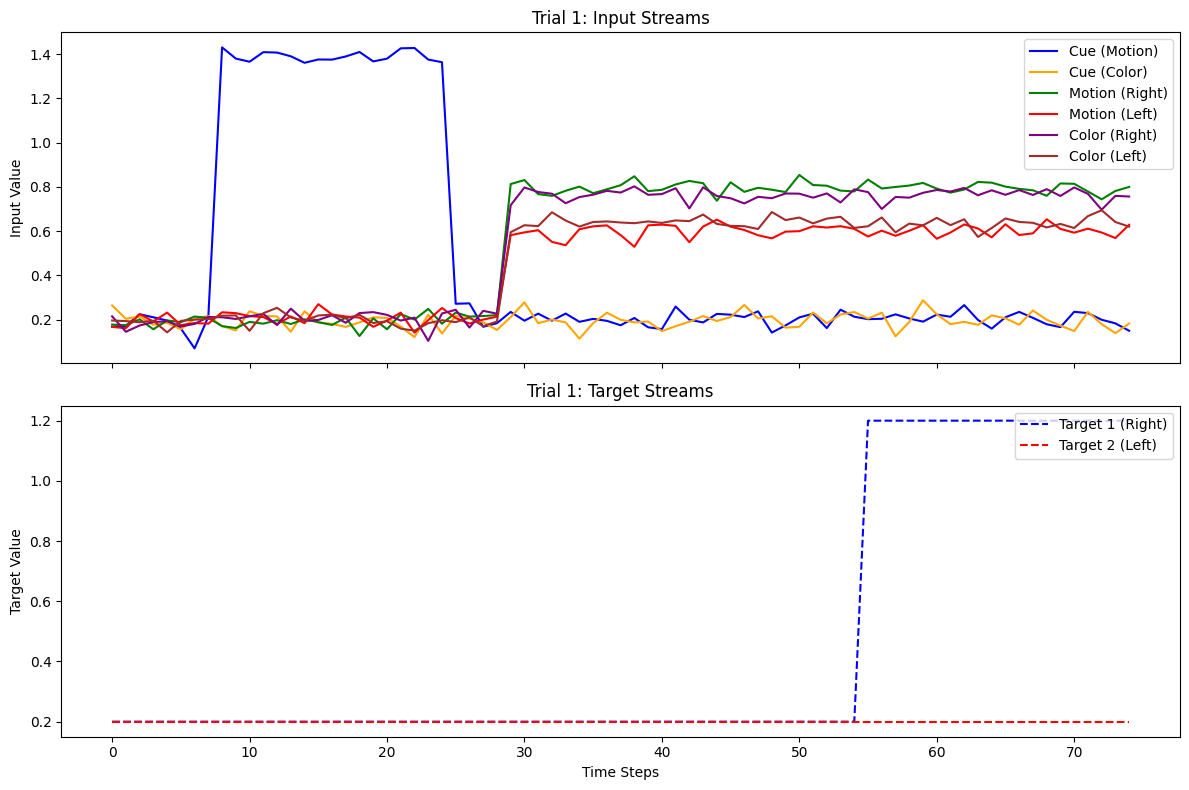

In [4]:
def visualize_trial(inputs, targets, trial_index):
    """
    Visualize the inputs and targets for a particular trial.
    
    :param inputs: Input data of shape (n_trials, n_t, 6)
    :param targets: Target data of shape (n_trials, n_t, 2)
    :param trial_index: Index of the trial to visualize
    """
    
    # Extract the inputs and targets for the given trial
    trial_inputs = inputs[trial_index].numpy()
    trial_targets = targets[trial_index].numpy()
    time_steps = trial_inputs.shape[0]
    
    # Create subplots for input and target streams
    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    # Plot the input streams
    axes[0].plot(range(time_steps), trial_inputs[:, 0], label='Cue (Motion)', color='blue')
    axes[0].plot(range(time_steps), trial_inputs[:, 1], label='Cue (Color)', color='orange')
    axes[0].plot(range(time_steps), trial_inputs[:, 2], label='Motion (Right)', color='green')
    axes[0].plot(range(time_steps), trial_inputs[:, 3], label='Motion (Left)', color='red')
    axes[0].plot(range(time_steps), trial_inputs[:, 4], label='Color (Right)', color='purple')
    axes[0].plot(range(time_steps), trial_inputs[:, 5], label='Color (Left)', color='brown')
    axes[0].set_title(f'Trial {trial_index}: Input Streams')
    axes[0].set_ylabel('Input Value')
    axes[0].legend(loc='upper right')
    
    # Plot the target streams
    axes[1].plot(range(time_steps), trial_targets[:, 0], label='Target 1 (Right)', color='blue', linestyle='--')
    axes[1].plot(range(time_steps), trial_targets[:, 1], label='Target 2 (Left)', color='red', linestyle='--')
    axes[1].set_title(f'Trial {trial_index}: Target Streams')
    axes[1].set_xlabel('Time Steps')
    axes[1].set_ylabel('Target Value')
    axes[1].legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()

# Example usage (assuming inputs and targets are in torch.Tensor format):
visualize_trial(u, z, trial_index=1)


#### Initialize and fit RNN model with 50 units and Dales Law constraint.

In [5]:
net = Net(n=50, input_size=6, dale=True, sigma_rec=0.15 )
net.fit(u, z, mask, lr=.01,
        epochs=150, 
        verbose=True, 
        weight_decay=0.001)
# Note: Due to random initialization of network parameters, not every run will result in a successful network.

Epoch: 5/150............. mse_z: 0.0412
Epoch: 10/150............. mse_z: 0.0413
Epoch: 15/150............. mse_z: 0.0283
Epoch: 20/150............. mse_z: 0.0174
Epoch: 25/150............. mse_z: 0.0102
Epoch: 30/150............. mse_z: 0.0110
Epoch: 35/150............. mse_z: 0.0106
Epoch: 40/150............. mse_z: 0.0100
Epoch: 45/150............. mse_z: 0.0195
Epoch: 50/150............. mse_z: 0.0170
Epoch: 55/150............. mse_z: 0.0091
Epoch: 60/150............. mse_z: 0.0053
Epoch: 65/150............. mse_z: 0.0092
Epoch: 70/150............. mse_z: 0.0098
Epoch: 75/150............. mse_z: 0.0101
Epoch: 80/150............. mse_z: 0.0151
Epoch: 85/150............. mse_z: 0.0073
Epoch: 90/150............. mse_z: 0.0195
Epoch: 95/150............. mse_z: 0.0081
Epoch: 100/150............. mse_z: 0.0145
Epoch: 105/150............. mse_z: 0.0063
Epoch: 110/150............. mse_z: 0.0089
Epoch: 115/150............. mse_z: 0.0078
Epoch: 120/150............. mse_z: 0.0092
Epoch: 125/1

##### Model accuracy evaluation

In [6]:
u_test, z_test, mask_test, conditions_test  = generate_trials( n_trials=25,
                                                alpha=float(0.2),
                                                sigma_in=0.01,
                                                baseline=.2,
                                                n_coh=15)
dense_model_accuracy = net.evaluate(u_test, z_test, batch_size=128)
print(f'Dense Model Test Accuracy: {dense_model_accuracy:.2f}')

Dense Model Test Accuracy: 95.35


#### Visualize connectivity parameters of RNN after training

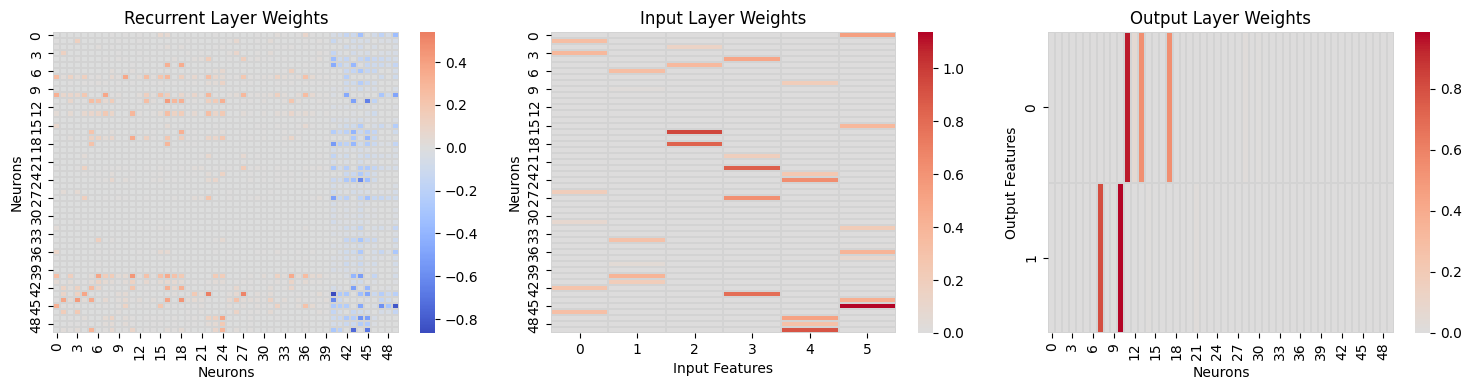

In [7]:
# Get the weight matrices
recurrent_weight_matrix = net.recurrent_layer.weight.data.detach().numpy()
input_weight_matrix = net.input_layer.weight.data.detach().numpy()
output_weight_matrix = net.output_layer.weight.data.detach().numpy()

# Create subplots to visualize all weight matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot Recurrent Layer Weights
sns.heatmap(recurrent_weight_matrix, center=0, cmap='coolwarm', linewidths=0.1, linecolor='lightgray', ax=axes[0])
axes[0].set_title('Recurrent Layer Weights')
axes[0].set_xlabel('Neurons')
axes[0].set_ylabel('Neurons')

# Plot Input Layer Weights
sns.heatmap(input_weight_matrix, center=0, cmap='coolwarm', linewidths=0.1, linecolor='lightgray', ax=axes[1])
axes[1].set_title('Input Layer Weights')
axes[1].set_xlabel('Input Features')
axes[1].set_ylabel('Neurons')

# Plot Output Layer Weights
sns.heatmap(output_weight_matrix, center=0, cmap='coolwarm', linewidths=0.1, linecolor='lightgray', ax=axes[2])
axes[2].set_title('Output Layer Weights')
axes[2].set_xlabel('Neurons')
axes[2].set_ylabel('Output Features')

# Adjust layout for better visibility
plt.tight_layout()
plt.show()


##### Low rank matrix in W_recurrent

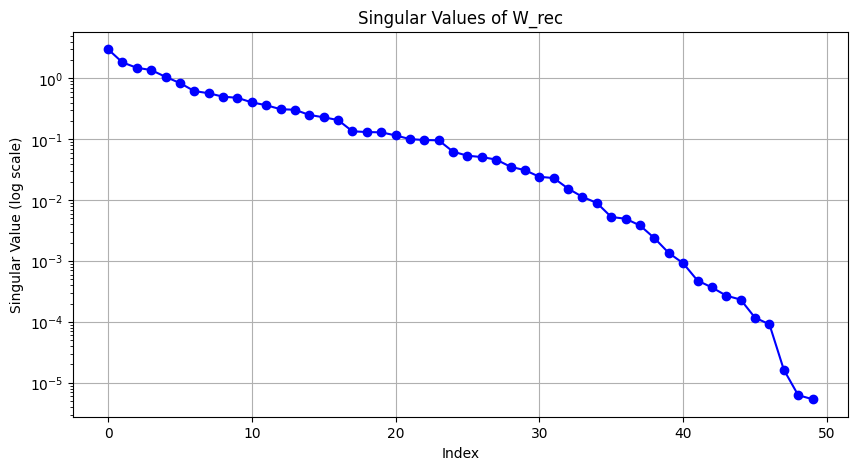

Frobenius norm error of rank-10 approximation: 0.1925


In [17]:
def low_rank_approximation(W_rec, k):
    # Perform SVD
    U, s, Vt = np.linalg.svd(W_rec, full_matrices=False)
    
    # Reconstruct using only top k singular values
    W_rec_low_rank = U[:, :k] @ np.diag(s[:k]) @ Vt[:k, :]
    
    return W_rec_low_rank, s, U, Vt

# Choose rank for approximation
k = 10

# Compute low-rank approximation
W_rec_low_rank, singular_values, U, Vt = low_rank_approximation(recurrent_weight_matrix, k)

# Calculate approximation error
error = np.linalg.norm(recurrent_weight_matrix - W_rec_low_rank, 'fro') / np.linalg.norm(recurrent_weight_matrix, 'fro')

# Plot singular values
plt.figure(figsize=(10, 5))
plt.semilogy(singular_values, 'b-o')
plt.title('Singular Values of W_rec')
plt.xlabel('Index')
plt.ylabel('Singular Value (log scale)')
plt.grid(True)
plt.show()

print(f"Frobenius norm error of rank-{k} approximation: {error:.4f}")

<Axes: >

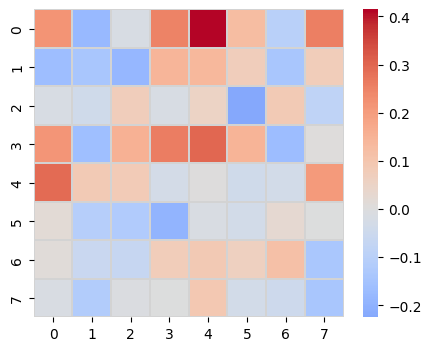

In [30]:
low_rank_pruned = U[:, :8].T @ recurrent_weight_matrix @ Vt[:, :8]
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(low_rank_pruned, center=0, cmap='coolwarm', linewidths=0.1, linecolor='lightgray',ax=ax)

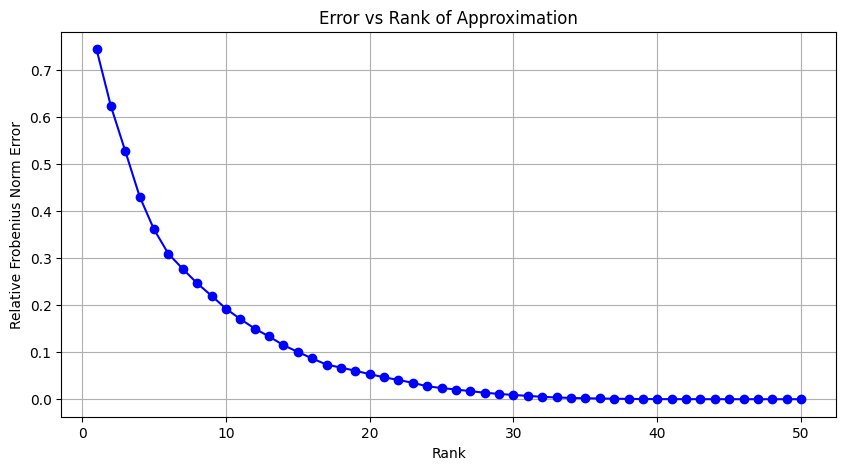

Frobenius norm error of rank-5 approximation: 0.3608
Frobenius norm error of rank-10 approximation: 0.1925
Frobenius norm error of rank-20 approximation: 0.0532
Frobenius norm error of rank-50 approximation: 0.0000

Rank needed to explain 95% of variance: 9


In [16]:
def low_rank_approximation(W_rec, k):
    U, s, Vt = np.linalg.svd(W_rec, full_matrices=False)
    W_rec_low_rank = U[:, :k] @ np.diag(s[:k]) @ Vt[:k, :]
    return W_rec_low_rank, s

def plot_error_vs_rank(W_rec, max_rank):
    errors = []
    for k in range(1, max_rank + 1):
        W_rec_low_rank, _ = low_rank_approximation(W_rec, k)
        error = np.linalg.norm(W_rec - W_rec_low_rank, 'fro') / np.linalg.norm(W_rec, 'fro')
        errors.append(error)
    
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, max_rank + 1), errors, 'b-o')
    plt.title('Error vs Rank of Approximation')
    plt.xlabel('Rank')
    plt.ylabel('Relative Frobenius Norm Error')
    plt.grid(True)
    plt.show()

n=50

# Plot error vs rank
plot_error_vs_rank(recurrent_weight_matrix, max_rank=50)

# Calculate and print errors for specific ranks
for k in [5, 10, 20, 50]:
    W_rec_low_rank, _ = low_rank_approximation(recurrent_weight_matrix, k)
    error = np.linalg.norm(recurrent_weight_matrix - W_rec_low_rank, 'fro') / np.linalg.norm(recurrent_weight_matrix, 'fro')
    print(f"Frobenius norm error of rank-{k} approximation: {error:.4f}")

# Calculate percentage of variance explained
_, s = low_rank_approximation(recurrent_weight_matrix, n)
cumulative_variance = np.cumsum(s**2) / np.sum(s**2)

# Find rank that explains 95% of variance
rank_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"\nRank needed to explain 95% of variance: {rank_95}")

##### weight examination and pruning

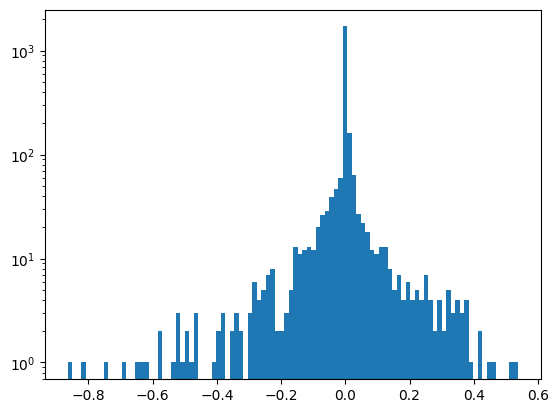

In [8]:
plt.hist(recurrent_weight_matrix.flatten(), bins=100);
plt.yscale('log')

In [10]:
def get_model_macs(model, inputs) -> int:
    return profile_macs(model, inputs)


def get_sparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

In [11]:
def fine_grained_prune(tensor: torch.Tensor, sparsity : float) -> torch.Tensor:
    """
    magnitude-based pruning for single tensor
    :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
    :param sparsity: float, pruning sparsity
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    :return:
        torch.(cuda.)Tensor, mask for zeros
    """
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()

    ##################### YOUR CODE STARTS HERE #####################
    # Step 1: calculate the #zeros (please use round())
    num_zeros = round(num_elements*sparsity)
    # Step 2: calculate the importance of weight
    importance = torch.abs(tensor)
    # Step 3: calculate the pruning threshold
    threshold = threshold = torch.kthvalue(importance.view(-1), num_zeros).values
    # Step 4: get binary mask (1 for nonzeros, 0 for zeros)
    mask = torch.gt(importance, threshold).type_as(tensor)
    ##################### YOUR CODE ENDS HERE #######################

    # Step 5: apply mask to prune the tensor
    tensor.mul_(mask)

    return mask

In [12]:
class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1: # we only prune conv and fc weights
                masks[name] = fine_grained_prune(param, sparsity_dict[name])
        return masks

In [13]:
@torch.no_grad()
def sensitivity_scan(net, u, z, scan_step=0.1, scan_start=0.4, scan_end=1.0, batch_size=128, verbose=True):
    """
    Perform sensitivity scanning on the network layers by pruning a certain percentage of weights
    and evaluating the accuracy at different sparsity levels.
    
    :param net: The instance of the network (Net class).
    :param u: Input data tensor.
    :param z: True labels tensor.
    :param scan_step: Step size for sparsity levels (default=0.1).
    :param scan_start: Starting sparsity level (default=0.4).
    :param scan_end: Ending sparsity level (default=1.0).
    :param batch_size: Batch size for evaluation (default=128).
    :param verbose: If True, prints progress and results.
    
    :return: Tuple (sparsities, accuracies), where sparsities is an array of sparsity levels, and
             accuracies is a list of accuracies for each sparsity level.
    """
    # Define sparsity levels
    sparsities = np.arange(start=scan_start, stop=scan_end, step=scan_step)
    accuracies = []

    # Identify the fully connected layers (input_layer, recurrent_layer, output_layer)
    named_fc_weights = [(name, param) for (name, param) in net.named_parameters() if param.dim() > 1]

    # Loop over layers and sparsities to evaluate performance
    for i_layer, (name, param) in enumerate(named_fc_weights):
        param_clone = param.detach().clone()  # Backup the original weights
        layer_accuracies = []

        for sparsity in tqdm(sparsities, desc=f'Scanning {i_layer+1}/{len(named_fc_weights)} layer - {name}'):
            # Perform fine-grained pruning by zeroing out a certain percentage of weights
            fine_grained_prune(param, sparsity=sparsity)

            # Evaluate the model's accuracy after pruning
            acc = net.evaluate(u, z, batch_size=batch_size)
            layer_accuracies.append(acc)

            if verbose:
                print(f'\r    Layer: {name}, sparsity={sparsity:.2f}: accuracy={acc:.2f}%', end='')

            # Restore original weights
            param.copy_(param_clone)

        accuracies.append(layer_accuracies)

        if verbose:
            print(f'\r    Layer: {name}, sparsity=[{", ".join(["{:.2f}".format(x) for x in sparsities])}]: accuracy=[{", ".join(["{:.2f}%".format(x) for x in layer_accuracies])}]')

    return sparsities, accuracies


In [19]:
sparsities, accuracies = sensitivity_scan(
    net, u_test, z_test, scan_step=0.02, scan_start=0.9, scan_end=1.0)

Scanning 1/3 layer - recurrent_layer.weight:  20%|██        | 1/5 [00:01<00:07,  1.97s/it]

    Layer: recurrent_layer.weight, sparsity=0.90: accuracy=95.18%

Scanning 1/3 layer - recurrent_layer.weight:  40%|████      | 2/5 [00:04<00:06,  2.02s/it]

    Layer: recurrent_layer.weight, sparsity=0.92: accuracy=91.15%

Scanning 1/3 layer - recurrent_layer.weight:  60%|██████    | 3/5 [00:05<00:03,  1.96s/it]

    Layer: recurrent_layer.weight, sparsity=0.94: accuracy=95.22%

Scanning 1/3 layer - recurrent_layer.weight:  80%|████████  | 4/5 [00:07<00:01,  1.93s/it]

    Layer: recurrent_layer.weight, sparsity=0.96: accuracy=84.29%

Scanning 1/3 layer - recurrent_layer.weight: 100%|██████████| 5/5 [00:09<00:00,  1.94s/it]


    Layer: recurrent_layer.weight, sparsity=[0.90, 0.92, 0.94, 0.96, 0.98]: accuracy=[95.18%, 91.15%, 95.22%, 84.29%, 68.82%]


Scanning 2/3 layer - input_layer.weight:  20%|██        | 1/5 [00:01<00:07,  1.86s/it]

    Layer: input_layer.weight, sparsity=0.90: accuracy=94.58%

Scanning 2/3 layer - input_layer.weight:  40%|████      | 2/5 [00:03<00:05,  1.87s/it]

    Layer: input_layer.weight, sparsity=0.92: accuracy=94.43%

Scanning 2/3 layer - input_layer.weight:  60%|██████    | 3/5 [00:05<00:03,  1.88s/it]

    Layer: input_layer.weight, sparsity=0.94: accuracy=94.15%

Scanning 2/3 layer - input_layer.weight:  80%|████████  | 4/5 [00:07<00:01,  1.88s/it]

    Layer: input_layer.weight, sparsity=0.96: accuracy=71.26%

Scanning 2/3 layer - input_layer.weight: 100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


    Layer: input_layer.weight, sparsity=[0.90, 0.92, 0.94, 0.96, 0.98]: accuracy=[94.58%, 94.43%, 94.15%, 71.26%, 72.20%]


Scanning 3/3 layer - output_layer.weight:  20%|██        | 1/5 [00:01<00:07,  1.91s/it]

    Layer: output_layer.weight, sparsity=0.90: accuracy=94.59%

Scanning 3/3 layer - output_layer.weight:  40%|████      | 2/5 [00:03<00:05,  1.90s/it]

    Layer: output_layer.weight, sparsity=0.92: accuracy=94.62%

Scanning 3/3 layer - output_layer.weight:  60%|██████    | 3/5 [00:05<00:03,  1.88s/it]

    Layer: output_layer.weight, sparsity=0.94: accuracy=94.44%

Scanning 3/3 layer - output_layer.weight:  80%|████████  | 4/5 [00:07<00:01,  1.88s/it]

    Layer: output_layer.weight, sparsity=0.96: accuracy=94.52%

Scanning 3/3 layer - output_layer.weight: 100%|██████████| 5/5 [00:09<00:00,  1.91s/it]

    Layer: output_layer.weight, sparsity=[0.90, 0.92, 0.94, 0.96, 0.98]: accuracy=[94.59%, 94.62%, 94.44%, 94.52%, 94.28%]


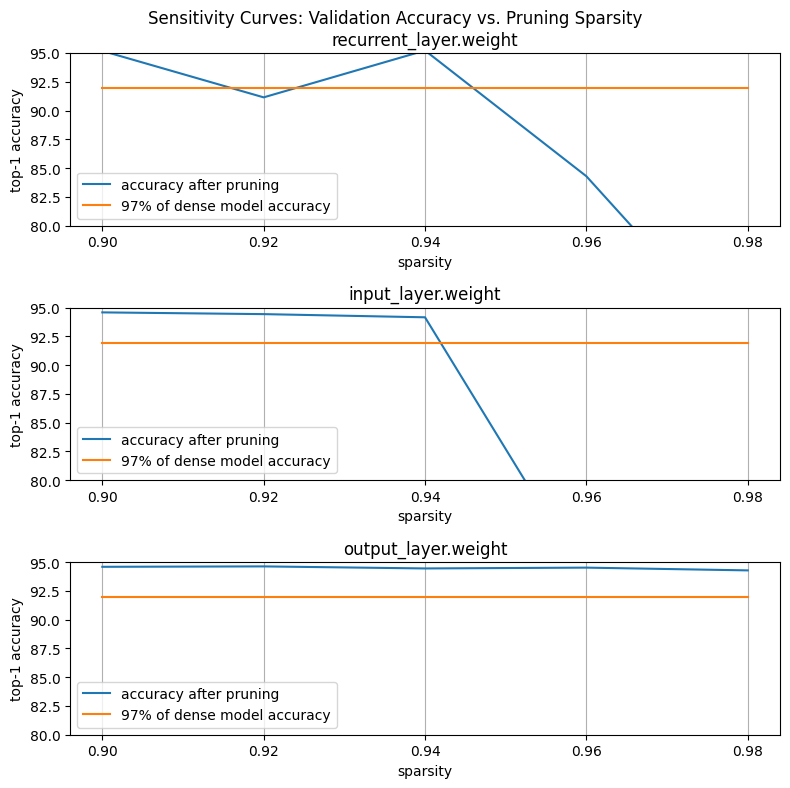

In [21]:
def plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy):
    lower_bound_accuracy = 100 - (100 - dense_model_accuracy) * 1.5
    fig, axes = plt.subplots(3, int(math.ceil(len(accuracies) / 3)),figsize=(8,8))
    axes = axes.ravel()
    plot_index = 0
    for name, param in net.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            curve = ax.plot(sparsities, accuracies[plot_index])
            line = ax.plot(sparsities, [lower_bound_accuracy] * len(sparsities))
            ax.set_xticks(np.arange(start=0.9, stop=1.0, step=0.02))
            ax.set_ylim(80, 95)
            ax.set_title(name)
            ax.set_xlabel('sparsity')
            ax.set_ylabel('top-1 accuracy')
            ax.legend([
                'accuracy after pruning',
                f'{lower_bound_accuracy / dense_model_accuracy * 100:.0f}% of dense model accuracy'
            ])
            ax.grid(axis='x')
            plot_index += 1
    fig.suptitle('Sensitivity Curves: Validation Accuracy vs. Pruning Sparsity')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy)

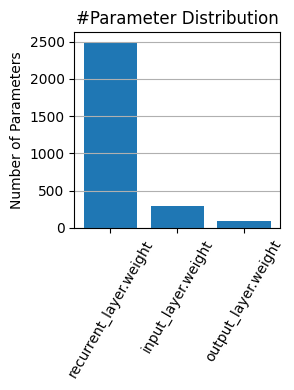

In [27]:
# parameters of each layer
def plot_num_parameters_distribution(model):
    num_parameters = dict()
    for name, param in model.named_parameters():
        if param.dim() > 1:
            num_parameters[name] = param.numel()
    fig = plt.figure(figsize=(3, 4))
    plt.grid(axis='y')
    plt.bar(list(num_parameters.keys()), list(num_parameters.values()))
    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

plot_num_parameters_distribution(net)

#### Plot psychometric functions for trained RNN

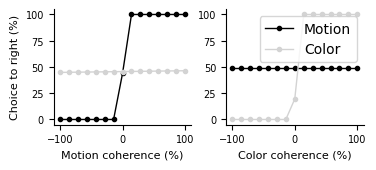

In [24]:

u, _, _, conditions  = generate_trials( n_trials=25,
                                                alpha=float(0.2),
                                                sigma_in=0.01,
                                                baseline=.2,
                                                n_coh=15)
df = psychometric(net,u,conditions)

## Fit latent circuit model to trained RNN

#### Initialize and fit latent circuit model

In [22]:
# Initialize
latent_net = LatentNet(n=8, N=net.n ,input_size=6, n_trials = u.shape[0],sigma_rec = 0.15)

# Generate inputs to simulate RNN
u, _, _, _  = generate_trials( n_trials=25,
                                                alpha=float(0.2),
                                                sigma_in=0.01,
                                                baseline=.2,
                                                n_coh=6)
# Simulate RNN
y = net(u)
z = net.output_layer(y)
# Fit latent circuit model
loss_history = latent_net.fit(u.detach(),z.detach(),y.detach(),epochs = 500,lr = .02,l_y = 1,weight_decay = 0.001)

Epoch: 0/500............. mse_z: 0.3559 nmse_y: 0.8797
Epoch: 10/500............. mse_z: 0.1102 nmse_y: 0.2932
Epoch: 20/500............. mse_z: 0.0337 nmse_y: 0.1011
Epoch: 30/500............. mse_z: 0.0349 nmse_y: 0.1061
Epoch: 40/500............. mse_z: 0.0236 nmse_y: 0.0751
Epoch: 50/500............. mse_z: 0.0236 nmse_y: 0.0750
Epoch: 60/500............. mse_z: 0.0214 nmse_y: 0.0708
Epoch: 70/500............. mse_z: 0.0220 nmse_y: 0.0765
Epoch: 80/500............. mse_z: 0.0215 nmse_y: 0.0712
Epoch: 90/500............. mse_z: 0.0212 nmse_y: 0.0692
Epoch: 100/500............. mse_z: 0.0206 nmse_y: 0.0739
Epoch: 110/500............. mse_z: 0.0211 nmse_y: 0.0740
Epoch: 120/500............. mse_z: 0.0210 nmse_y: 0.0672
Epoch: 130/500............. mse_z: 0.0203 nmse_y: 0.0676
Epoch: 140/500............. mse_z: 0.0198 nmse_y: 0.0685
Epoch: 150/500............. mse_z: 0.0191 nmse_y: 0.0673
Epoch: 160/500............. mse_z: 0.0200 nmse_y: 0.0663
Epoch: 170/500............. mse_z: 0.0203 

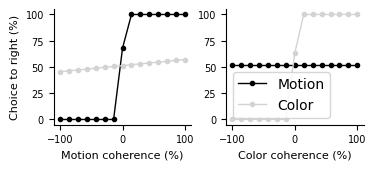

In [23]:
# Plot psychometric functions
u, z, mask, conditions  = generate_trials( n_trials=25,
                                                alpha=float(0.2),
                                                sigma_in=0.01,
                                                baseline=.2,
                                                n_coh=15)
df = psychometric(latent_net,u,conditions)

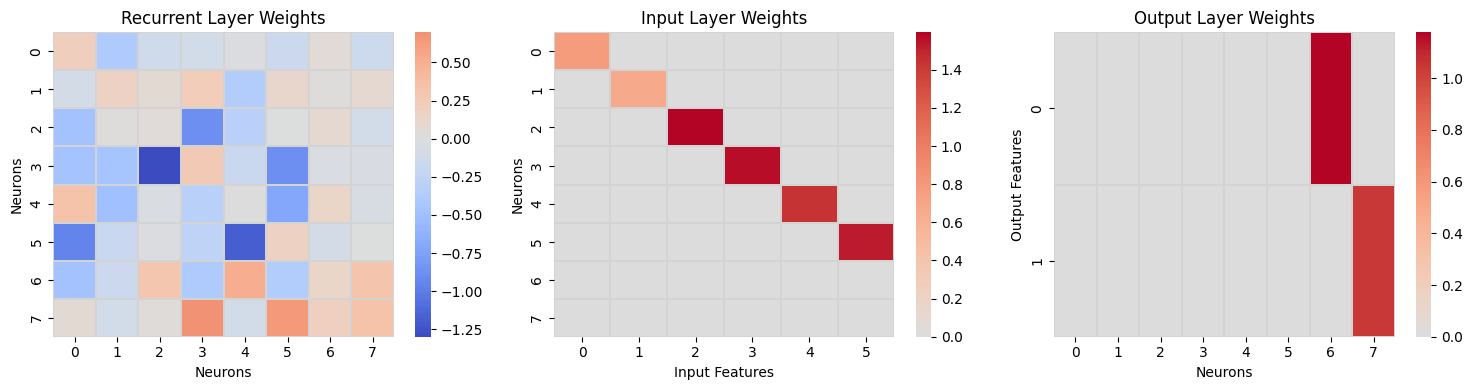

In [28]:
# Get the weight matrices
recurrent_weight_matrix = latent_net.recurrent_layer.weight.data.detach().numpy()
input_weight_matrix = latent_net.input_layer.weight.data.detach().numpy()
output_weight_matrix = latent_net.output_layer.weight.data.detach().numpy()

# Create subplots to visualize all weight matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot Recurrent Layer Weights
sns.heatmap(recurrent_weight_matrix, center=0, cmap='coolwarm', linewidths=0.1, linecolor='lightgray', ax=axes[0])
axes[0].set_title('Recurrent Layer Weights')
axes[0].set_xlabel('Neurons')
axes[0].set_ylabel('Neurons')

# Plot Input Layer Weights
sns.heatmap(input_weight_matrix, center=0, cmap='coolwarm', linewidths=0.1, linecolor='lightgray', ax=axes[1])
axes[1].set_title('Input Layer Weights')
axes[1].set_xlabel('Input Features')
axes[1].set_ylabel('Neurons')

# Plot Output Layer Weights
sns.heatmap(output_weight_matrix, center=0, cmap='coolwarm', linewidths=0.1, linecolor='lightgray', ax=axes[2])
axes[2].set_title('Output Layer Weights')
axes[2].set_xlabel('Neurons')
axes[2].set_ylabel('Output Features')

# Adjust layout for better visibility
plt.tight_layout()
plt.show()


## Assessing fit quality of latent circuit model
There are several ways to assess the quality of fit of the latent circuit model.
1) Agreement between $Qx$ and $y$ where $x$ is the responses of the latent model, $y$ is the responses of the RNN and $Q$ is the orthonormal matrix that maps $x$ onto $y$.
2) Agreement between $x$ and $Q^Ty$ i.e. agreement in the subspace spanned by the columns of $Q$.
3) Agreement between $w_{rec}$ and $Q^TW_{rec}Q$.

#### 1) Agreement between $Qx$ and $y$

(-0.2075901307165623, 1.4979500897228717)

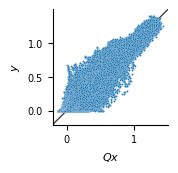

In [9]:
u, _, _, _  = generate_trials( n_trials=25,
                                                alpha=float(0.2),
                                                sigma_in=0.01,
                                                baseline=.2,
                                                n_coh=6)
y  = net(u).detach()
qx = latent_net(u)@latent_net.q
fig = plt.figure(figsize=(1.5,1.5))
gs = gridspec.GridSpec(1,1)
ax=fig.add_subplot(gs[0,0])
sns.scatterplot(x =qx.detach().flatten(),y = y.flatten(),ax=ax,s=2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("", fontsize=8)
ax.xaxis.set_tick_params(labelsize=7,bottom=True)
ax.yaxis.set_tick_params(labelsize=7,left=True)
ax.set_xlabel(r"$Qx$", fontsize=8)
ax.set_ylabel(r"$y$", fontsize=8)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0,lw=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

#### 2) Agreement between $x$ and $Q^Ty$

(-0.22601358592510223, 1.8837337017059326)

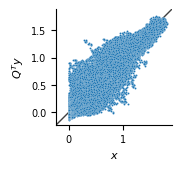

In [10]:
u, _, _, _  = generate_trials( n_trials=25,
                                                alpha=float(0.2),
                                                sigma_in=0.01,
                                                baseline=.2,
                                                n_coh=6)
qty  = net(u).detach()@latent_net.q.t()
x = latent_net(u)
fig = plt.figure(figsize=(1.5,1.5))
gs = gridspec.GridSpec(1,1)
ax=fig.add_subplot(gs[0,0])
sns.scatterplot(x =x.detach().flatten(),y = qty.detach().flatten(),ax=ax,s=2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("", fontsize=8)
ax.xaxis.set_tick_params(labelsize=7,bottom=True)
ax.yaxis.set_tick_params(labelsize=7,left=True)
ax.set_xlabel(r"$x$", fontsize=8)
ax.set_ylabel(r"$Q^Ty$", fontsize=8)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0,lw=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

#### 3) Agreement between $w_{rec}$ and $Q^TW_{rec}Q$

Text(0.5, 1.0, '$Q^Tw_{rec}Q$')

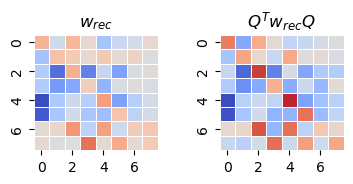

In [11]:
w_rec = latent_net.recurrent_layer.weight.data.detach()
q = latent_net.q.detach()
W_rec = net.recurrent_layer.weight.data.detach()

# Plot
fig = plt.figure(figsize=(4,1.5))
gs = gridspec.GridSpec(1,2,wspace = .5)
ax0=fig.add_subplot(gs[0,0])
ax1=fig.add_subplot(gs[0,1])

sns.heatmap(w_rec, ax=ax0, cmap='coolwarm',center=0,cbar=False,lw=.5)
ax0.set_title(r"$w_{rec}$")
sns.heatmap(q@W_rec@q.T, ax=ax1, cmap='coolwarm',center=0,cbar=False,lw=.5)
ax1.set_title(r"$Q^Tw_{rec}Q$")